# Single-regime GBM: ElasticNet Top-N strategy

This notebook explores the behavior of a simple **ElasticNet Top-N** selection strategy in a **baseline market with no predictability**.

We simulate a universe of $K$ i.i.d. GBM tickers with shared $(\mu, \sigma)$ parameters over a fixed horizon $T$, and run a monthly walk-forward backtest where an ElasticNet model predicts next-month returns from past features.

Because the universe follows i.i.d. GBM dynamics (independent increments, identical drift and volatility) the features contain no predictive information. Any apparent signal is purely noise, and Top-N selections are effectively random conditional on the information set.

The goal of this experiment is to establish a null reference case:

- to validate our backtesting pipeline against known theoretical expectations (volatility scaling, growth behavior, rebalancing premium);

- to quantify the performance drag of predictive models in the absence of signal, due to turnover and concentration risk;

- and to provide a baseline benchmark for later scenarios.

## Expectations

Under i.i.d. GBM dynamics, all tickers share the same drift $\mu$ and volatility $\sigma$, and returns are independent over time and across assets. This implies that no predictive edge can be extracted from the past. Any machine learning model trained on such data behaves effectively like a random selector.

### Basket growth and volatility

For an equal-weight basket of $K$ independent GBM paths, the expected wealth matches a single path:

$$
\mathbb{E}[V_\mathrm{EW}(t)] = e^{\mu t}.
$$

<!-- An equal-weight basket's expected equity $V_\mathrm{EW}$ matches a single path's expectation:
$$
\mathbb{E}[V_\mathrm{EW}(t)] = \mathbb{E}\left[\sum_{i=1}^K \dfrac{V_\mathrm{EW}(0)}{K} \dfrac{S_i(t)}{S_i(0)}\right] = \dfrac{V_\mathrm{EW}(0)}{K} \sum_{i=1}^K \mathbb{E}\left[\dfrac{S_i(t)}{S_i(0)}\right] = \dfrac{V_\mathrm{EW}(0)}{K} \sum_{i=1}^K e^{\mu t} = V_\mathrm{EW}(0) e^{\mu t},
$$
thus, when using normalized initial equity, the expected terminal wealth is $\mathbb{E}\left[V_\mathrm{EW}^T\right] = e^{\mu T}$. -->

The basket variance simplifies (by independence and identical distribution) to:

$$
\mathrm{Var}\left[V_\mathrm{EW}(t)\right] = \dfrac{1}{K} e^{2\mu t} \left(e^{\sigma^2t} - 1\right),
$$
and for small $t$ ($e^{\sigma^2t} - 1 \approx \sigma^2 t$) the instantaneous relative volatility becomes

<!-- An equal-weight basket's volatility scales with $K^{-1/2}$ compared to a single path's volatility. We calculate the variance of the basket using normalized initial equity:
$$
\mathrm{Var}\left[V_\mathrm{EW}(t)\right] = \mathrm{Var}\left[\sum_{i=1}^K \dfrac{1}{K} \dfrac{S_i(t)}{S_i(0)}\right] = \sum_{i=1}^K \mathrm{Var}\left[\dfrac{1}{K} \dfrac{S_i(t)}{S_i(0)}\right] = \dfrac{1}{K^2} \sum_{i=1}^K e^{2\mu t} \left(e^{\sigma^2t} - 1\right) = \dfrac{1}{K} e^{2\mu t} \left(e^{\sigma^2t} - 1\right).
$$
For small $t$ we get $e^{\sigma^2t} - 1 \approx \sigma^2 t$, such that the instantaneous relative volatility of the basket is: -->

$$
\sigma_\mathrm{EW} = \dfrac{\sqrt{\mathrm{Var}\left[V_\mathrm{EW}(t)\right]}}{\mathbb{E}[V_\mathrm{EW}(t)]} = \dfrac{1}{\sqrt{K}} \sigma \sqrt{t},
$$

featuring a $K^{-1/2} scaling with the number of constitutents.$

### ElasticNet Top-N strategy

An ElasticNet Top-N strategy concentrates capital on a smaller subset ($N<K$). Without any true signal:

- The Top-N picks are effectively random,

- portfolio volatility scales as $\sigma_\mathrm{Top-N} \approx \sigma N^{-1/2}$,

- and expected terminal wealth is reduced relative to equal-weight benchmarks due to:
    - Transaction cost drag from monthly turnover, and

    - Volatility drag, as higher volatility lowers the geometric mean growth rate $g_\mathrm{geom} = \mu - \tfrac{1}{2}\sigma^2$.

### Benchmarks

Two benchmarks are considered:
- Buy & Hold EW — no rebalancing.

- Monthly Rebalance EW — equal-weighting restored monthly.

#### Rebalancing premium

Rebalancing can capture a small volatility-harvesting premium when returns are imperfectly correlated. In the i.i.d. case, this effect is minor but measurable. Transaction costs can offset or eliminate this effect.

#### Volatility scaling

The theoretical $K^{-1/2}$ volatility scaling only holds for portfolios with constant weights. In Buy & Hold, weight drift increases concentration, effectively lowering $K_\mathrm{eff}$ ($\rightarrow$ Herfindahl–Hirschman index), so realized volatility exceeds the theoretical value for the instantaneous relative volatility. Monthly rebalancing mitigates this drift and keeps volatility closer to theory.

### Expected performance ordering

Over many seeds and long horizons, we expect

$$
V^T_\mathrm{MR} \gtrapprox V^T_\mathrm{BH} > V^T_\mathrm{Top-N} \qquad \mathrm{and} \qquad \sigma_\mathrm{MR} \lessapprox \sigma_\mathrm{BH} < \sigma_\mathrm{Top-N},
$$

where $V^T$ indicates the terminal wealth at the end time $T$, and $\sigma$ are the realized volatilities.

## Setup

We simulate a universe of $K$ i.i.d. GBM tickers with shared drift $\mu$ and volatility $\sigma$ over a fixed horizon $T$. The goal is to evaluate the relative performance of an ElasticNet Top-N strategy against equal-weight benchmarks in an environment without predictive structure.

### Universe and horizon

- $K$ = 250 i.i.d. GBM tickers with parameters $(\mu=0.1, \sigma=0.25)$

- $T=10$ years on a business day calendar

- Rebalancing on month-end

- $S = 50$ independent random seeds (universes) to estimate variability

### Strategies

- **ElasticNet Top-N** — selects $N \in {5, 10, 20, 50, 100}$ tickers each month and invests equal weight in them for the next period.

- **Buy & Hold EW** — equal-weight across $K$ tickers at $t=0$, no further rebalancing.

- **Monthly Rebalance EW** — equal-weight across $K$ tickers, rebalanced monthly.

### Walk-forward training

- Expanding window: at month $t$, train only on data strictly before $t$.

- Features:

    - 12–1 momentum (compound return from $t-12$ to $t-2$)

    - 1-month realized volatility (from $t-1$)

- Target: next-month simple return $r_{t\to t+1}$

- Model: scikit-learn ElasticNet with standardization ($\alpha = 0.001$, $l_1$ ratio $= 0.5$).

### Trading and costs

- Rebalance at month-end.

- Transaction costs $c = 10$ bps per side applied to turnover.

- Positions sized equal-weight within the selected subset.

### Evaluation

For each strategy and each seed, we compute:

- Performance metrics: Terminal wealth, CAGR, arithmetic mean, volatility (annualized), Sharpe (rf = 0), max drawdown, turnover (annualized).

- Comparisons vs benchmarks:

    - $\Delta$ log growth-rate, terminal-wealth ratio, win-rate

    - p-value for $H_0: p = 0.5$ (null: ENet performs no better than benchmark)

## Results

This section summarizes the performance of the ElasticNet Top-N strategy relative to equal-weight benchmarks in an i.i.d. GBM universe. We focus on four aspects that directly test the theoretical expectations:

1. Geometric-mean wealth curves over time,

2. Volatility scaling with Top-N,

3. Performance differentials (Δ log growth-rate distributions),

4. Summary performance metrics.

In [ ]:
# here we run the experiment, may take up to 10 minutes with standard parameters
from mlbt.notebooks.runners import run_gbm_enetv0_single_experiment
results = run_gbm_enetv0_single_experiment(
    gbm_start="2000-01-01",
    gbm_end="2009-12-31",
    n_runs=50,
    n_tickers=250,
    mu=0.1,
    sigma=0.25,
    cost_bps=10,
    master_seed=1990,
    verbose=False
)

20-10-2025 12:37:34 | INFO | {'gbm_start': '2000-01-01', 'gbm_end': '2009-12-31', 'n_runs': 50, 'n_tickers': 250, 'mu': 0.1, 'sigma': 0.25, 'cost_bps': 10, 'master_seed': 1990, 'verbose': False}
20-10-2025 12:37:38 | WARNING | Building month grid (remove this warning at some point, currently warns because we do not want to build month grid unnecessary)
20-10-2025 12:45:56 | INFO | Number of universe constitutents: 250
20-10-2025 12:45:56 | INFO | Mean one-factor universe correlation: 0.00001
20-10-2025 12:45:56 | INFO | Investment horizon in years: 8.84


### 1. Geometric-mean log equity across seeds

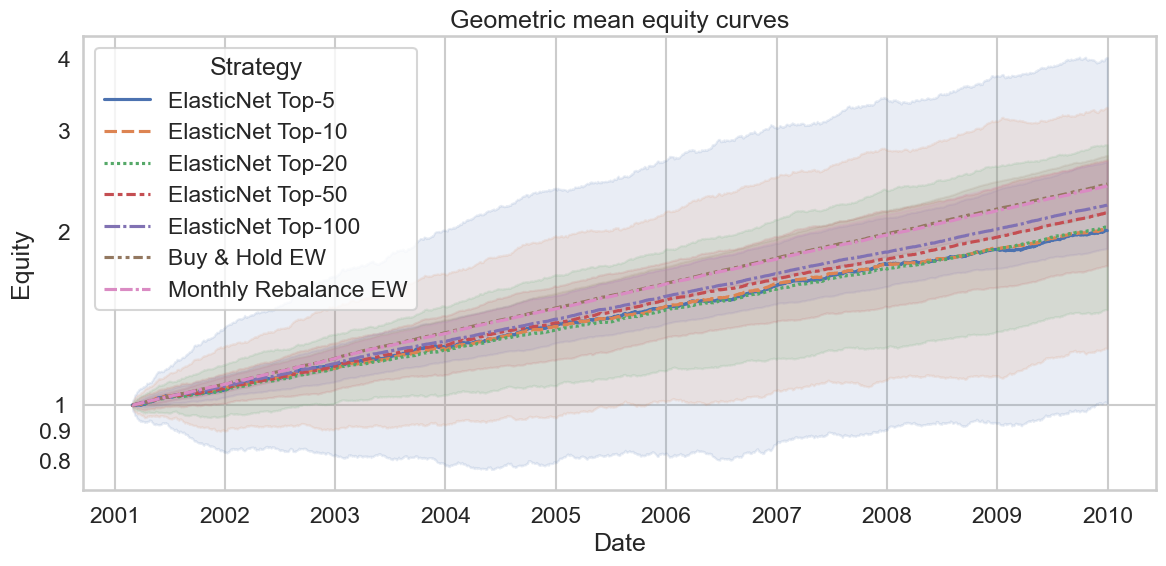

In [2]:
from mlbt.visualisation import plot_equities
_ = plot_equities(
    equities=list(results["geometric_mean_equity"][0].values()),
    bands=results["geometric_mean_equity"][1],
    title="Geometric mean equity curves",
    log_y=True)

We plot the geometric mean equity curves across all $S$ random seeds, with shaded regions indicating 95% confidence intervals. Curves are displayed on a log scale to highlight differences in long-run growth rates rather than levels.

In GBM, the ensemble mean of equity grows as 
$$
\mathbb{E}[V(t)] = V_0 e^{\mu t}
$$
while the median (or equivalently $\exp[\mathbb{E}[\ln V(t)]]$) grows as
$$
\mathrm{median}\left[V(t)\right] = V_0 e^{\left(\mu - \tfrac{1}{2}\sigma^2\right)t}.
$$

The gap of $\tfrac{1}{2}\sigma^2$ corresponds to volatility drag, the reason typical paths underperform the mean in multiplicative processes.

By plotting the geometric mean, i.e. $e^{\overline{\ln V(t)}}$, we focus on the typical outcome rather than the arithmetic ensemble average, which would be dominated by a few large winners. This is also more meaningful from a portfolio perspective, since in practice we observe only one realization of the strategy, not its expected outcome over infinite runs.

We find that:
- The two equal-weight benchmarks (Buy & Hold and Monthly Rebalance) track each other closely throughout the horizon, consistent with the negligible rebalancing premium expected under i.i.d. GBM.

- As $N$ increases, the CI bands contract, reflecting the reduced portfolio risk/lower volatility from larger basket sizes.

- Top-N strategies trail the benchmarks, with performance deteriorating as $N$ decreases.

- As $N \rightarrow K$, the ElasticNet strategy converges to the benchmark curve.

### 2. Volatility scaling with $N$

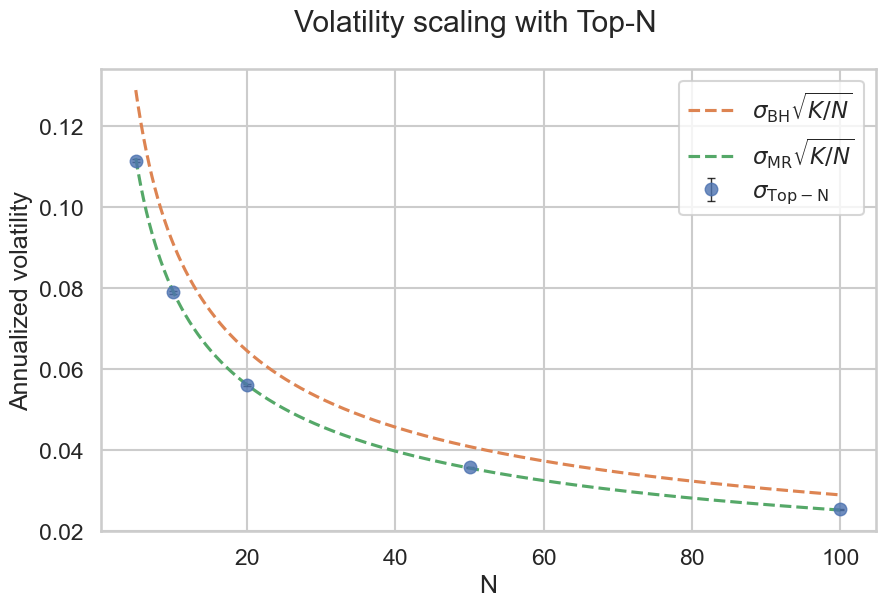

In [3]:
from mlbt.visualisation import plot_vol_curve
_ = plot_vol_curve(results["mean_metrics"], bench=["Buy & Hold EW", "Monthly Rebalance EW"])

We compare realized mean annualized volatility $\sigma_\mathrm{Top-N}$ for each Top-N strategy to the theoretical scalings
$$
\sigma_\mathrm{Top-N} = \sigma_{BH/MR} \sqrt{\dfrac{K}{N}},
$$
where $\sigma_{BH/MR}$ are the realized benchmark volatilities for Buy & Hold and Monthly Rebalance, respectively.

- Buy & Hold exhibits slightly higher realized volatility than Monthly Rebalance. This reflects weight drift: in Buy & Hold, weights are not re-equalized, so capital concentrates in random winners over time. The effective number of constituents $K_{\rm eff}$ decreases, increasing realized volatility.

- Top-N strategies, which also rebalance monthly, align closely with the expected $\sqrt{K}/\sqrt{N}$ scaling relative to the Monthly Rebalance benchmark.

This validates that our simulation and backtesting engine preserve the expected volatility structure of random baskets.

### 3. $\Delta$ log growth-rate distributions

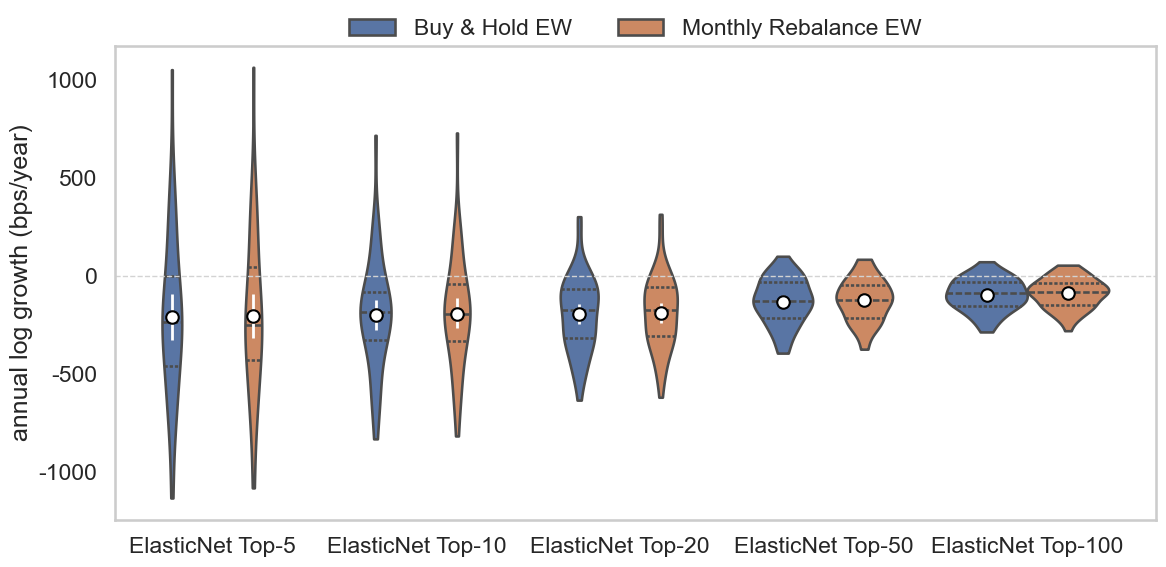

In [5]:
from mlbt.visualisation import plot_ann_log_growth_statistics
_ = plot_ann_log_growth_statistics(
    df=results["delta_log_growth"],
    stats=results["delta_log_growth_stats"])

To quantify performance differences, we examine the distribution of

$$
\Delta \ln{V^T} = \ln{V^T_\mathrm{Top-N}} - \ln{V^T_\mathrm{benchmark}}
$$

across seeds for each Top-N strategy. The violin plot display the mean $\Delta$ log growth-rates together with 95% bootstrapped confidence intervals (white).

We find that:
- All Top-N strategies have negative mean $\Delta$ log growth relative to both benchmarks.

- The effect magnitude increases as $N$ decreases, reflecting higher volatility and turnover costs in smaller baskets.

- This pattern is consistent with the null hypothesis: no predictive signal leads to systematic underperformance due to cost and volatility drag.

- As $N$ increases, the resulting log growth-rate distributions become more concentrated around the mean, representing yet again a decrease in volatility.

In Appendix A we provide detailed numeric summary tables comparing each strategy against each benchmark including:

- mean $\Delta$ log growth-rate,

- terminal wealth ratio,

- win-rate, and

- $p$-value for $H_0 : p = 0.5$.

The violin plots already convey the key result: systematic underperformance of Top-N strategies in the absence of signal, while the appendix tables provide precise numerical values for reference.

### 4. Summary performance metrics

In [7]:
from IPython.display import Markdown
from mlbt.outputs import prep_metrics_df
summary = prep_metrics_df(
    metrics_df=results["mean_metrics"],
    delta_log_growth_stats=results["delta_log_growth_stats"]
)
display(Markdown(summary))

|                      |   Total Return |   CAGR |   Arithmetic Mean |    Vol |   Sharpe |   MaxDD |   Turnover |   Delta log growth vs MR |   Win-rate vs MR |
|:---------------------|---------------:|-------:|------------------:|-------:|---------:|--------:|-----------:|-------------------------:|-----------------:|
| Monthly Rebalance EW |         1.408  | 0.1044 |            0.0995 | 0.0159 |   6.2708 |  0.0078 |     0.6895 |                 nan      |           nan    |
| Buy & Hold EW        |         1.4267 | 0.1053 |            0.1003 | 0.0182 |   5.5008 |  0.0103 |   nan      |                 nan      |           nan    |
| ElasticNet Top-100   |         1.2346 | 0.0948 |            0.0909 | 0.0253 |   3.5953 |  0.0193 |     8.8861 |                  -0.0087 |             0.12 |
| ElasticNet Top-50    |         1.1705 | 0.091  |            0.0877 | 0.0357 |   2.4592 |  0.0372 |    11.8178 |                  -0.0122 |             0.08 |
| ElasticNet Top-20    |         1.0659 | 0.0841 |            0.0821 | 0.056  |   1.4668 |  0.08   |    13.5656 |                  -0.0187 |             0.1  |
| ElasticNet Top-10    |         1.0925 | 0.0838 |            0.0833 | 0.0789 |   1.0555 |  0.1302 |    14.2031 |                  -0.0191 |             0.18 |
| ElasticNet Top-5     |         1.1402 | 0.083  |            0.0852 | 0.1115 |   0.7637 |  0.2053 |    14.7943 |                  -0.0203 |             0.28 |

Key takeaways:

- Monthly Rebalance EW and Buy & Hold EW deliver nearly identical growth, with Buy & Hold featuring larger growth. This means that the rebalance premium is overcompensated by turnover costs. 

- Nevertheless, due to its lower volatility, Monthly Rebalance scores the highest Sharpe ratio among all strategies.

- ElasticNet Top-N strategies underperform systematically, with larger performance gaps at smaller $N$ due to increased volatility and costs.

- Sharpe ratios scale cleanly with basket volatility.

- Turnover costs introduce an additional performance drag that grows with decreasing $N$.

## Discussion

This experiment confirms all major theoretical expectations under i.i.d. GBM:

- Volatility scaling closely follows the expected $N^{-1/2}$ relationship.

- Predictive strategies with no signal systematically underperform due to a combination of turnover costs and volatility drag from concentration.

- The rebalancing premium is marginal in this setting, as expected for independent assets.

- Weight drift explains the volatility gap between Buy & Hold and Monthly Rebalance benchmarks.

These results establish a clear baseline null model: when there is no predictive structure in returns, machine learning strategies cannot create an edge. Future scenarios with correlations, regime shifts, or mixed universes can be evaluated against this benchmark to isolate the incremental effect of those structures.

Note: Although the ElasticNet feature coefficients gradually shrink toward zero as the training window expands, small fluctuations in fitted noise continue to produce non-zero scores. This leads to changing Top-N selections at each rebalance date. Consequently, the strategy keeps readjusting its $N$ constitutents, rather than converging to a fixed $N$ out of $K$ portfolio, even in the complete absence of predictive signal.

## Appendix A - Detailed Performance Tables

This appendix contains a detailed numerical comparison for the growth between each ElasticNet Top-N strategy and each benchmark from Results subsection 4. A total of 10 tables are included (5 Top-N strategies $\times$ 2 benchmarks). While the main text focuses on the statistical patterns and scaling behavior, these tables provide the exact numerical values for reference and replication.

In [9]:
from mlbt.outputs import md_ann_log_growth_stats_table
r = md_ann_log_growth_stats_table(
    stats=results["delta_log_growth_stats"],
    T=results["years"],
    alt="less")
display(Markdown(r))

### ElasticNet Top-10 vs Buy & Hold EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0200` | [`-0.0276`, `-0.0122`] |
| Terminal wealth ratio | `0.8381` | [`0.7836`, `0.8976`] |
| Win-rate | `0.2000` | [`0.1124`, `0.3304`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `1.19e-05` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-10 vs Monthly Rebalance EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0191` | [`-0.0266`, `-0.0113`] |
| Terminal wealth ratio | `0.8443` | [`0.7902`, `0.9049`] |
| Win-rate | `0.1800` | [`0.0977`, `0.3080`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `2.81e-06` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-100 vs Buy & Hold EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0096` | [`-0.0119`, `-0.0073`] |
| Terminal wealth ratio | `0.9189` | [`0.9004`, `0.9372`] |
| Win-rate | `0.1400` | [`0.0695`, `0.2619`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `1.05e-07` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-100 vs Monthly Rebalance EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0087` | [`-0.0109`, `-0.0067`] |
| Terminal wealth ratio | `0.9257` | [`0.9084`, `0.9425`] |
| Win-rate | `0.1200` | [`0.0562`, `0.2380`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `1.62e-08` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-20 vs Buy & Hold EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0196` | [`-0.0247`, `-0.0143`] |
| Terminal wealth ratio | `0.8411` | [`0.8038`, `0.8815`] |
| Win-rate | `0.1200` | [`0.0562`, `0.2380`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `1.62e-08` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-20 vs Monthly Rebalance EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0187` | [`-0.0239`, `-0.0137`] |
| Terminal wealth ratio | `0.8473` | [`0.8096`, `0.8861`] |
| Win-rate | `0.1000` | [`0.0435`, `0.2136`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `2.10e-09` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-5 vs Buy & Hold EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0212` | [`-0.0326`, `-0.0093`] |
| Terminal wealth ratio | `0.8293` | [`0.7496`, `0.9210`] |
| Win-rate | `0.2600` | [`0.1587`, `0.3955`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `4.68e-04` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-5 vs Monthly Rebalance EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0203` | [`-0.0315`, `-0.0090`] |
| Terminal wealth ratio | `0.8354` | [`0.7567`, `0.9234`] |
| Win-rate | `0.2800` | [`0.1747`, `0.4167`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `1.30e-03` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-50 vs Buy & Hold EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0131` | [`-0.0164`, `-0.0099`] |
| Terminal wealth ratio | `0.8909` | [`0.8652`, `0.9166`] |
| Win-rate | `0.1400` | [`0.0695`, `0.2619`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `1.05e-07` |  |

✅ *Reject H₀ at 5% level*

---

### ElasticNet Top-50 vs Monthly Rebalance EW

| Metric | Estimate | 95% CI |
|:-------|---------:|:-------|
| Δ log growth-rate | `-0.0122` | [`-0.0153`, `-0.0093`] |
| Terminal wealth ratio | `0.8975` | [`0.8736`, `0.9211`] |
| Win-rate | `0.0800` | [`0.0315`, `0.1884`] |
| p-value (H₀: r=0.5, H₁: r<0.5) | `2.23e-10` |  |

✅ *Reject H₀ at 5% level*